In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import kagglehub
import os
import shutil
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print("Chemin de l'archive téléchargée :", path)

# Dossier de destination pour déplacer l'archive
destination_dir = "./amazonreviews_dataset"
os.makedirs(destination_dir, exist_ok=True)

# Chemin complet de l'archive dans le dossier de destination
# Récupère le nom de l'archive (ex: "archive.zip")
archive_name = os.path.basename(path)
new_archive_path = os.path.join(destination_dir, archive_name)

# Déplacer l'archive vers le dossier de destination
shutil.move(path, new_archive_path)
print(f"Archive déplacée vers : {new_archive_path}")

# Dossier pour extraire l'archive
extract_dir = os.path.join(destination_dir, "amazonreviews")
os.makedirs(extract_dir, exist_ok=True)
print(f"Archive extraite dans : {extract_dir}")

c:\Users\alexi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resuming download from 236978176 bytes (280102789 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/bittlingmayer/amazonreviews?dataset_version_number=7 (236978176/517080965) bytes left.


100%|██████████| 493M/493M [00:08<00:00, 33.5MB/s]

Extracting files...


Chemin de l'archive téléchargée : C:\Users\alexi\.cache\kagglehub\datasets\bittlingmayer\amazonreviews\versions\7
Archive déplacée vers : ./amazonreviews_dataset\7
Archive extraite dans : ./amazonreviews_dataset\amazonreviews


In [2]:

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Loading Data

In [3]:
train_data = pd.read_csv('./amazonreviews_dataset/7/train.ft.txt.bz2',
                         delimiter='\t',compression='bz2',header=None)

In [4]:
test_data = pd.read_csv('./amazonreviews_dataset/7/test.ft.txt.bz2', 
                        delimiter='\t',compression='bz2',header=None)
test_data.head()

,0
0,__label__2 Great CD: My lovely Pat has one of ...
1,__label__2 One of the best game music soundtra...
2,__label__1 Batteries died within a year ...: I...
3,"__label__2 works fine, but Maha Energy is bett..."
4,__label__2 Great for the non-audiophile: Revie...


In [5]:
train_data.head()

,0
0,__label__2 Stuning even for the non-gamer: Thi...
1,__label__2 The best soundtrack ever to anythin...
2,__label__2 Amazing!: This soundtrack is my fav...
3,__label__2 Excellent Soundtrack: I truly like ...
4,"__label__2 Remember, Pull Your Jaw Off The Flo..."


In [6]:
def extract_labl(data):
    label=[]
    for i in data[0]:
        labl=i.split()[0]
        label.append(int(labl.replace("__label__", "")))
    return label

## Label Extraction

In [7]:
test_data['label']=pd.Series(extract_labl(test_data))
test_data['label'].head()

0    2
1    2
2    1
3    2
4    2
Name: label, dtype: int64

In [8]:
train_data['label']=pd.Series(extract_labl(train_data))
train_data['label'].head()

0    2
1    2
2    2
3    2
4    2
Name: label, dtype: int64

In [9]:

train_data[0] = train_data[0].map(lambda x: " ".join(x.split()[1:]))


In [10]:

test_data[0] = test_data[0].map(lambda x: " ".join(x.split()[1:]))


In [11]:
train_data = train_data.rename(columns={0: 'text'})
print(train_data.columns)

test_data = test_data.rename(columns={0: 'text'})
print(train_data.columns)

Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


# Data Preprocessing

## Spliting data

In [42]:
X=train_data.text
y=train_data.label
X_valid=test_data.text
y_valid=test_data.label

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
tokn=Tokenizer(num_words=20000)
tokn.fit_on_texts(X_train)
tokn.fit_on_texts(X_valid)

In [43]:
tokenized_sentences = tokn.texts_to_sequences(X_train)
tkn_valid_sentences = tokn.texts_to_sequences(X_valid)

In [16]:
tkn_tst=tokn.texts_to_sequences(X_test)

In [17]:
X_train_prcs = pad_sequences(tokenized_sentences, maxlen=100)

In [44]:
X_valid_prcs = pad_sequences(tkn_valid_sentences, maxlen=100)

In [18]:
X_test_prcs=pad_sequences(tkn_tst, maxlen=100)

In [41]:
X_test_prcs[0]

array([   7,    4,  362,    7,  947, 4166,  513, 5945, 5660, 3581,    2,
        581, 3961,  744,  370,  169,  794,   23,  300,  532,   17,  106,
         45,  290,  120, 3581,   13,   27,   22,  309,    2,   13, 3102,
         68,    1, 5945,   49,    3,  261,    5,    1, 3581,  229,  700,
        262,  118,    2,    1, 1787,   36,    1, 5291,  167,  581, 3961,
        744,   13,  413,  376, 3117,    2,    6,  910,  118,   10,  279,
         68,  169,  796,  217,    1,  170,    9,    4, 4748,    3,   97,
       1759,   21,  211,   88,    9, 1048,    5,   90, 1167,   45, 2316,
          2, 1377,  903,  636,    3,   97,  841,  180,   72, 3062,    8,
        602])

In [19]:
y_train = np.array(y_train, dtype=np.int32)
y_train = y_train - y_train.min()
y_train = utils.to_categorical(y_train, num_classes=2)
print(y_train[:1])
print(y_train.shape)

[[0. 1.]]
(2880000, 2)


In [20]:
y_test = np.array(y_test, dtype=np.int32)
y_test = y_test - y_test.min()

In [45]:
y_valid = np.array(y_valid, dtype=np.int32)
y_valid = y_valid - y_valid.min()
y_valid = utils.to_categorical(y_valid, num_classes=2)
print(y_valid[:1])
print(y_valid.shape)

[[0. 1.]]
(400000, 2)


In [21]:
print(type(X_train_prcs), X_train_prcs.shape)
print(type(y_train), y_train.shape)

<class 'numpy.ndarray'> (2880000, 100)
<class 'numpy.ndarray'> (2880000, 2)


# Building Model

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=20000,output_dim=128,input_length=100))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64)) 
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])




c:\Users\alexi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
# # Callback  
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

# model_checkpoint = ModelCheckpoint(
#     'best_model.keras', 
#     save_best_only=True, 
#     monitor='val_accuracy')


In [24]:
history = model.fit(
    X_train_prcs, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=1200,
    callbacks=[early_stopping])


Epoch 1/8
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2170s 1s/step - accuracy: 0.8916 - loss: 0.2575 - val_accuracy: 0.9360 - val_loss: 0.1657
Epoch 2/8
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1927s 1s/step - accuracy: 0.9422 - loss: 0.1545 - val_accuracy: 0.9393 - val_loss: 0.1583
Epoch 3/8
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1914s 997ms/step - accuracy: 0.9510 - loss: 0.1345 - val_accuracy: 0.9421 - val_loss: 0.1535
Epoch 4/8
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1753s 913ms/step - accuracy: 0.9577 - loss: 0.1187 - val_accuracy: 0.9426 - val_loss: 0.1534
Epoch 5/8
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1752s 912ms/step - accuracy: 0.9635 - loss: 0.1045 - val_accuracy: 0.9428 - val_loss: 0.1628
Epoch 6/8
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1756s 915ms/step - accuracy: 0.9686 - loss: 0.0919 - val_accuracy: 0.9421 - val_loss: 0.1664
Epoch 7/8
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1750s 911ms/step - accuracy: 0.9732 - loss: 0.0800 - val_accuracy: 0.9398 - val_loss: 0.1824


In [25]:
y_train_pred = model.predict(X_train_prcs)

90000/90000 ━━━━━━━━━━━━━━━━━━━━ 1989s 22ms/step


In [26]:
y_train_pred = np.argmax(y_train_pred, axis=1)  
y_train_pred[:11]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

# Model Evaluation

In [27]:
print(classification_report(np.argmax(y_train, axis=1), y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96   1440241
           1       0.96      0.96      0.96   1439759

    accuracy                           0.96   2880000
   macro avg       0.96      0.96      0.96   2880000
weighted avg       0.96      0.96      0.96   2880000



In [46]:
y_valid_pred = model.predict(X_valid_prcs)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 729s 58ms/step


In [47]:
y_valid_pred = np.argmax(y_valid_pred, axis=1)

# Performance Metrics

In [53]:
print(classification_report(np.argmax(y_valid, axis=1), y_valid_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9450    0.9383    0.9416    200000
           1     0.9387    0.9454    0.9420    200000

    accuracy                         0.9418    400000
   macro avg     0.9419    0.9418    0.9418    400000
weighted avg     0.9419    0.9418    0.9418    400000



In [51]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_valid_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.941832


Text(0.5, 1.0, 'Confusion Matrix')

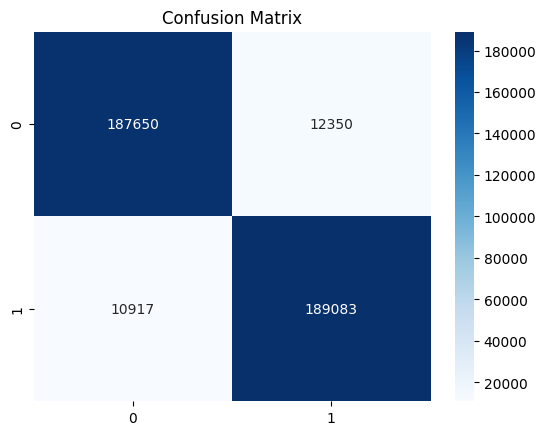

In [52]:
sns.heatmap(confusion_matrix(np.argmax(y_valid, axis=1),
            y_valid_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

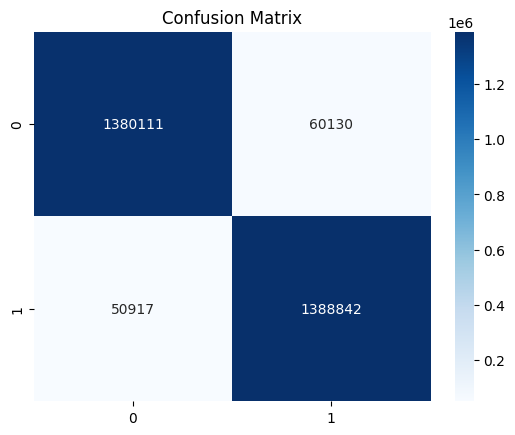

In [28]:
sns.heatmap(confusion_matrix(np.argmax(y_train, axis=1),y_train_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

In [29]:
y_pred = model.predict(X_test_prcs)

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 564s 25ms/step


In [30]:
y_pred = np.argmax(y_pred, axis=1)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94    359759
           1       0.94      0.95      0.94    360241

    accuracy                           0.94    720000
   macro avg       0.94      0.94      0.94    720000
weighted avg       0.94      0.94      0.94    720000



Text(0.5, 1.0, 'Confusion Matrix')

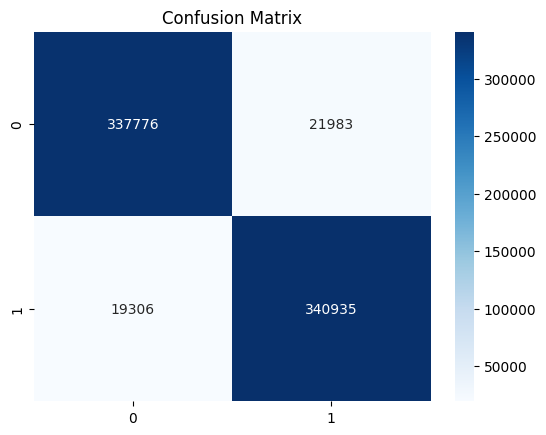

In [32]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

In [33]:
Token_test=tokn.texts_to_sequences(test_data.text)

In [34]:
Test_process=pad_sequences(Token_test, maxlen=100)

In [35]:
Test_true = np.array(test_data.label, dtype=np.int32)
Test_true = Test_true - Test_true.min()

In [36]:
Test_process.shape

(400000, 100)

In [37]:
Test_pred = model.predict(Test_process)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 321s 26ms/step


In [38]:
Test_pred = np.argmax(Test_pred, axis=1)

In [39]:
print(classification_report(Test_true, Test_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94    200000
           1       0.94      0.95      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



Text(0.5, 1.0, 'Confusion Matrix')

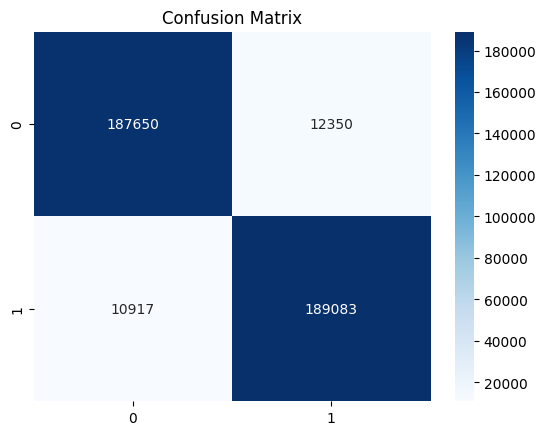

In [40]:
sns.heatmap(confusion_matrix(Test_true, Test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')